# Differential operators

In this notebook we will learn how to

* differentiate using differential operators (`diffop`) 

[Back to tensorgrid quick introduction](00_quick_introduction.ipynb). 

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import time

import numpy as np

import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex

import torch
from torch import exp, sin, cos, abs, real, imag, pi, max, diag, float32, eye, kron
from torch.linalg import norm, matrix_exp

error = lambda u, uref : max(abs(u.flatten()-uref.flatten()))

c:\ProgramData\Anaconda3\envs\torchcomplex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Differentiation operators - 1D

#### $\star$ `diffop`

All spatial discretizations implement differentiation operator `diffop`. The default behaviour of `diffop` in `tensorgrid` spatial discretization is to use Fourier spectral differentiation, which utilises Fast Fourier Transform (FFT) for differentiation. 

The syntax for differentiation of a function in 1D is:

```Python
    df = ex.diffop(0, 1, f, xrange)
    d2f = ex.diffop(0, 2, f, xrange)
```

Here `f` is a vector with values of a function $f$ on a grid. Then `df` is the `1`st derivative of $f$ in the `0`th direction (i.e. the first and only coordinate). We also have to specify the (optional) `xrange` of the grid on which $f$ is discretized - the defaul value is `[-1,1]` as usual across all functions in `expsolve.discretize.tensorgrid`. The $k$ th derivative is obtained as `ex.diffop(0, k, f, xrange)`. Later in this notebook we will also see how to differentiate a `2d` function in either direction ($x$ or $y$).


**NOTE:**

* The floating point precision used for internal operations (e.g. FFT) depends on the the precision of `f`. However, since FFTs are only available for `float32` and higher accuracies in PyTorch, by default `diffop` will fail for `float16` data (i.e. half precision).

* If `f` is real-valued, the derivatives `df` and `d2f` are also guaranteed to be real-valued. This is beneficial when working with real-valued PDEs.

* `f` needs to be periodic on `xrange`. If it is not, spurious oscillations should be expected. 

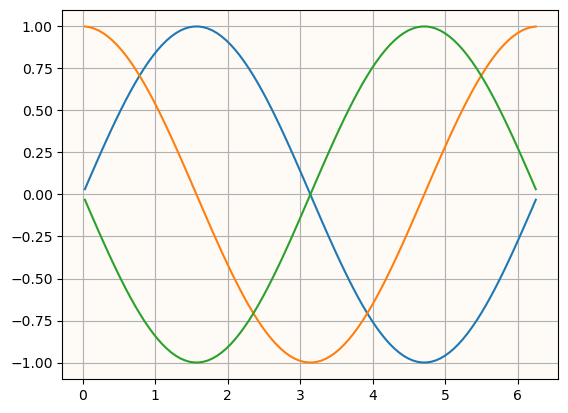

In [2]:
xrange = [0, 2*pi]
n = 100
x = ex.grid1d(n, xrange, dtype=float32)

s = sin(x)
ds = real(ex.diffop(0,1,s,xrange))      # 1st derivative of sin
d2s = real(ex.diffop(0,2,s,xrange))     # 2nd derivative of sin

fig, ax = plt.subplots()
ex.plot(ax, x, s)
ex.plot(ax, x, ds)
ex.plot(ax, x, d2s)
plt.show()

We can see that the derivative `ds` is `torch.float32`, which is consistent with accuracy of the grid `x` (and hence the function `s`), and it is real-valued.

In [3]:
print(ds)
print(ds.dtype)

tensor([[ 0.9995,  0.9956,  0.9877,  0.9759,  0.9603,  0.9409,  0.9178,  0.8910,
          0.8607,  0.8271,  0.7902,  0.7501,  0.7071,  0.6613,  0.6129,  0.5621,
          0.5090,  0.4540,  0.3971,  0.3387,  0.2790,  0.2181,  0.1564,  0.0941,
          0.0314, -0.0314, -0.0941, -0.1564, -0.2181, -0.2790, -0.3387, -0.3971,
         -0.4540, -0.5090, -0.5621, -0.6129, -0.6613, -0.7071, -0.7501, -0.7902,
         -0.8271, -0.8607, -0.8910, -0.9178, -0.9409, -0.9603, -0.9759, -0.9877,
         -0.9956, -0.9995, -0.9995, -0.9956, -0.9877, -0.9759, -0.9603, -0.9409,
         -0.9178, -0.8910, -0.8607, -0.8271, -0.7902, -0.7501, -0.7071, -0.6613,
         -0.6129, -0.5621, -0.5090, -0.4540, -0.3971, -0.3387, -0.2790, -0.2181,
         -0.1564, -0.0941, -0.0314,  0.0314,  0.0941,  0.1564,  0.2181,  0.2790,
          0.3387,  0.3971,  0.4540,  0.5090,  0.5621,  0.6129,  0.6613,  0.7071,
          0.7501,  0.7902,  0.8271,  0.8607,  0.8910,  0.9178,  0.9409,  0.9603,
          0.9759,  0.9877,  

Let's see how accurate the derivative computed in this way is. The true derivative of $\sin(x)$ is $\cos(x)$. 

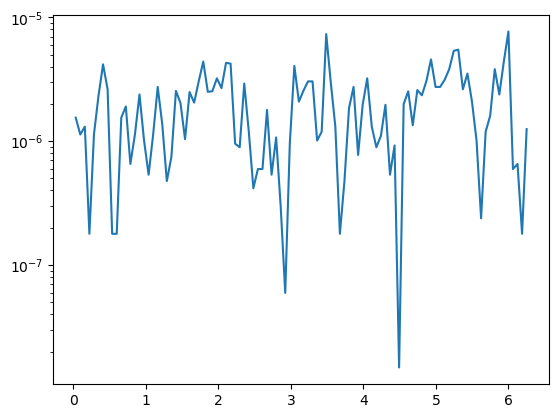

In [4]:
c = cos(x)
ex.semilogy(plt, x, abs(c-ds))
plt.show()

We can see that the derivative has $10^{-5}$ accuracy. In typical scientific applications, this is expected to be inadequate. The default choice of `float64` for the grid fixes this issue.

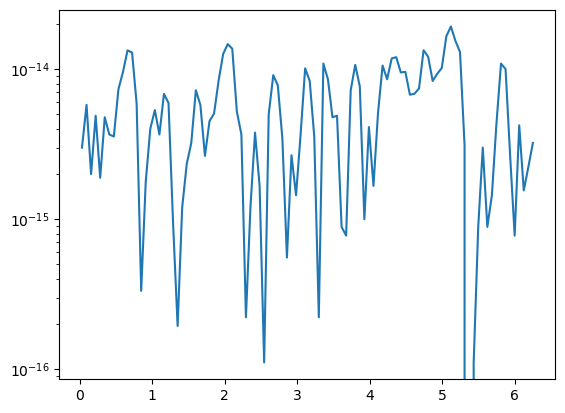

In [5]:
x = ex.grid1d(n, xrange)                # using default precision of `float64`
s = sin(x)
ds = real(ex.diffop(0,1,s,xrange))      # 1st derivative of sin
d2s = real(ex.diffop(0,2,s,xrange))     # 2nd derivative of sin

c = cos(x)
ex.semilogy(plt, x, abs(c-ds))
plt.show()

This shows us that the derivative computed in this way is extremely accurate. $\sin$ is a very simple function, of course. 

A more complicated example of a **periodic** function is $\exp(\sin(x))$ whose derivative is $\cos(x) \exp(\sin(x))$.

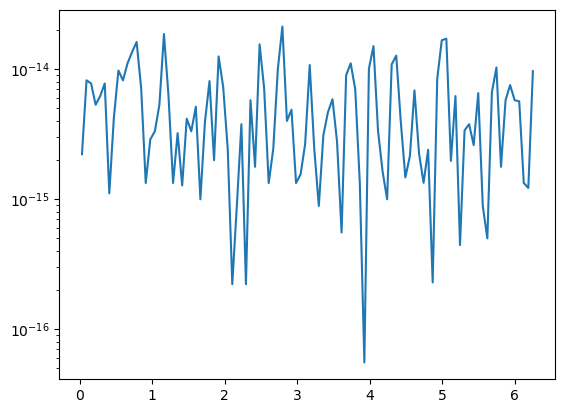

In [6]:
f = exp(sin(x))
df_true = cos(x)*exp(sin(x))
df_numerical = real(ex.diffop(0,1,f,xrange))

plt.semilogy(x.flatten(), abs(df_true-df_numerical).flatten())
plt.show()

Again, the computation looks accurate up to $14$ digits of precision!

#### Issues with non-periodicity

Differentiation in `tensorgrid` is ONLY accurate for smooth periodic functions! Let's see with an example:

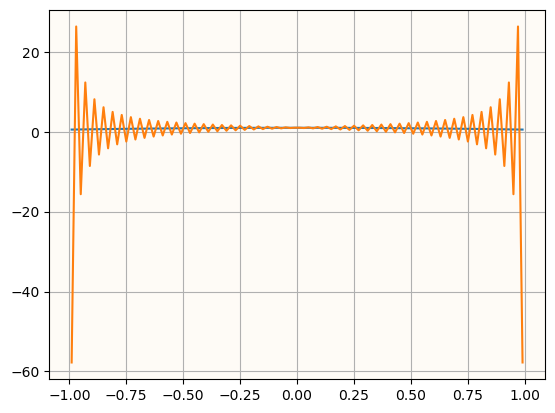

In [7]:
x = ex.grid1d(100)

s = sin(x)
ds_true = cos(x)
ds_numerical = real(ex.diffop(0, 1, s))

fig, ax = plt.subplots()
ex.plot(ax, x, ds_true)
ex.plot(ax, x, ds_numerical)
plt.show()

The computed derivative is extremely inaccurate since $sin$ is not periodic over $[-1,1]$ (note that we didn't specify `xrange` here, and so it defaults to `[-1,1]`).

Let's contrast this with a function that's periodic on $[-1,1]$:

<Figure size 640x480 with 0 Axes>

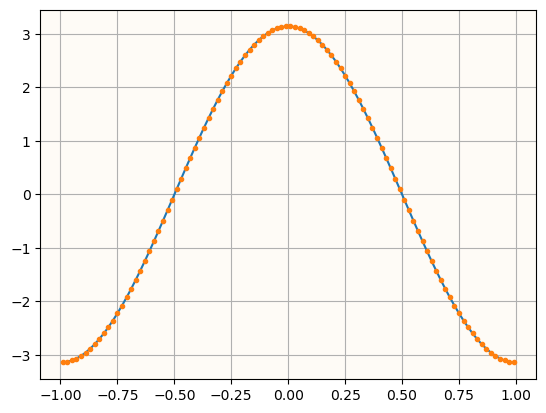

In [8]:
s = sin(pi*x)
ds_true = pi*cos(pi*x)
ds_numerical = real(ex.diffop(0, 1, s))

fig, ax = plt.subplots()
ex.plot(ax, x, ds_true)
ex.plot(ax, x, ds_numerical, marker='.', linestyle=' ')
plt.show()

## Differentiation operators - 2D

We consider the 2D function

$$ f= \sin(x+2y) + \exp(\sin(y)) \cos(y)$$

which is periodic over the grid $[0, 2 \pi]^2$ and whose (first) partial derivatives with respect to $x$ and $y$ are

$$\frac{\partial f}{\partial x} = \cos(x+2y) - \exp(\sin(y)) \sin(x)$$

and 

$$\frac{\partial f}{\partial y} = 2 \cos(x+2y) + \exp(\sin(y)) \cos(y) \cos(x), $$

which can be computed as

```Python
    dfx = ex.diffop(0, 1, f, xrange)
    dfy = ex.diffop(1, 1, f, xrange)
```

respectively. The second derivatives are:

$$\frac{\partial^2 f}{\partial x^2} = -\sin(x+2y) - \exp(\sin(y)) \cos(x)$$

and 

$$\frac{\partial^2 f}{\partial y^2} = -4 \sin(x+2y) + \exp(\sin(y)) \cos(y)^2 \cos(x) - \exp(\sin(y)) \sin(y) \cos(x), $$

which can be computed as 

```Python
    dfxx = ex.diffop(0, 2, f, xrange)
    dfyy = ex.diffop(1, 2, f, xrange)
```

while the mixed second derivative is

$$\frac{\partial^2 f}{\partial x \partial y} = -2 \sin(x+2y) - \exp(\sin(y)) \cos(y) \sin(x) $$


```Python
    dfxy = ex.diffop(1, 2, ex.diffop(0, 2, f, xrange), xrange)
```

Sometimes when `xrange` is fixed, the code *may* become more readable by defining `lambda` expressions for the differential operators. In the following example we will define 

* `Dx` for $\frac{\partial}{\partial x}$,
* `Dy` for $\frac{\partial}{\partial y}$,
* `Dxx` for $\frac{\partial^2}{\partial x^2}$,
* `Dyy` for $\frac{\partial^2}{\partial y^2}$, and
* `Lap` for the Laplacian,

$$ \Delta = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}.$$




In [9]:
xrange = [0, 2*pi]

Dx = lambda f: ex.diffop(0, 1, f, xrange)
Dy = lambda f: ex.diffop(1, 1, f, xrange)
Dxx = lambda f: ex.diffop(0, 2, f, xrange)
Dyy = lambda f: ex.diffop(1, 2, f, xrange)
Lap = lambda f: Dxx(f) + Dyy(f)

Now we can differentiate a function simply by applying `Dx` and `Dy` appropriate number of times.

In [10]:
n = 50
[x,y] = ex.grid([n,n], xrange)      # 2D grid

f = sin(x+2*y) + exp(sin(y))*cos(x)

dfx = Dx(f)
dfy = Dy(f)
dfxx = Dxx(f)
dfyy = Dyy(f)
dfxy = Dx(Dy(f))
Lf = Lap(f)

We visualize the mixed derivative and the Laplacian of `f` below

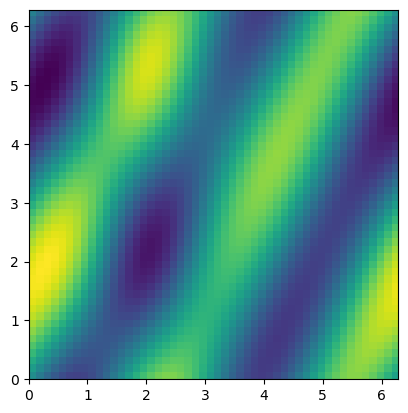

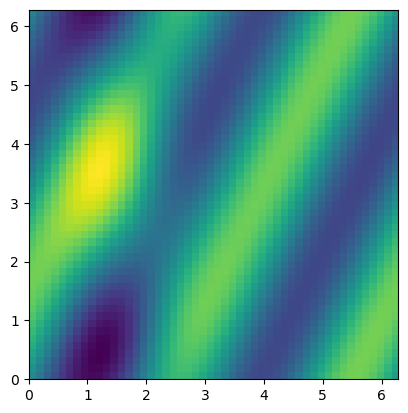

In [11]:
plt.figure()
ex.imshow(plt, xrange, dfxy)
plt.show()

plt.figure()
ex.imshow(plt, xrange, Lf)
plt.show()

Let us assess the accuracy of the derivatives

In [12]:
dfx_true = cos(x+2*y) - exp(sin(y))*sin(x)
dfy_true = 2*cos(x+2*y) + exp(sin(y))*cos(y)*cos(x)

dfxx_true = -sin(x+2*y) - exp(sin(y)) * cos(x)
dfyy_true = -4 * sin(x+2*y) + exp(sin(y)) * cos(y)**2 * cos(x) - exp(sin(y)) * sin(y) * cos(x)

dfxy_true = -2 * sin(x+2*y) - exp(sin(y)) * cos(y) * sin(x) 

print(error(dfx, dfx_true))
print(error(dfy, dfy_true))
print(error(dfxx, dfxx_true))
print(error(dfyy, dfyy_true))
print(error(dfxy, dfxy_true))

tensor(3.3751e-14, dtype=torch.float64)
tensor(3.6415e-14, dtype=torch.float64)
tensor(8.7955e-13, dtype=torch.float64)
tensor(6.2716e-13, dtype=torch.float64)
tensor(3.9169e-13, dtype=torch.float64)


Of course, it is not essential to define the lambda expressions for `diffop` - this merely makes your code easier to read. 

There are two ways to compute $\frac{\partial^2 f}{\partial x^2}$: apply `Dxx` (as we have shown), or apply `Dx` twice. Both are expected to be equivalent up to machine precision for large $n$. However, the second approach is expected to be twice as expensive. We show the second approach below:

In [13]:
dfxx_alternative = Dx(Dx(f))
print(error(dfxx_alternative, dfxx))

tensor(1.1369e-13, dtype=torch.float64)
